In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, precision_recall_curve

In [3]:
import mysql_connector_ssh_rsa

In [4]:
Con = mysql_connector_ssh_rsa.Connector

In [5]:
query = 'select * from `es-orders`.orders'
df = Con.mysql_connect(query)

In [6]:
df_filter = df[(df.status_id == 'DELETE') | (df.status_id == 'DONE')]

In [7]:
df_research = df_filter[['status_id', 'total', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration', 'distance_out_of_city', 'paid_by_cash', 'discount', 'tariff_param_id']]

In [8]:
df_research.status_id = df_research.status_id.map({'DONE': 1, 'DELETE': 0})

In [11]:
df_dummy = pd.get_dummies(df_research, columns=['cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration',  'tariff_param_id', 'discount'], drop_first=True)

In [12]:
numeric_cols = ['total', 'distance_feed', 'distance_return', 'distance_out_of_city', 'paid_by_cash' ]
cat_cols = list(set(df_dummy.columns) - set(numeric_cols) - {'status_id'})
cat_cols.sort()

In [15]:
random_seed = np.random.seed(0)
df_train, df_test = train_test_split(df_dummy, test_size=0.25, random_state=random_seed, stratify=df_dummy['status_id'])

In [18]:
scaler = StandardScaler()
scaler.fit(df_dummy[numeric_cols])

StandardScaler()

In [19]:
def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['status_id']
    return X, y

In [69]:
X, y = get_features_and_target_arrays(df_dummy, numeric_cols, cat_cols, scaler)

In [21]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

In [70]:
X.shape

(3999, 46)

In [74]:
n_features = X.shape[1]
model = Sequential()
model.add(Dense(int(round((n_features+1)/2)), input_shape=(n_features,), activation='relu'))
model.add(Dense(int(round((n_features+1)/4)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [136]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])

In [137]:
model.fit(X, y, epochs=300, batch_size=30)

Epoch 1/300
134/134 [==============================] - 1s 2ms/step - loss: 0.2518 - recall: 0.8248
Epoch 2/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2490 - recall: 0.8322
Epoch 3/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2490 - recall: 0.8240
Epoch 4/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2490 - recall: 0.8277
Epoch 5/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2467 - recall: 0.8233
Epoch 6/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2480 - recall: 0.8248
Epoch 7/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2479 - recall: 0.8404
Epoch 8/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2479 - recall: 0.8255
Epoch 9/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2478 - recall: 0.8345
Epoch 10/300
134/134 [==============================] - 0s 2ms/step - loss: 0.2486 - recall: 0.8248
Epoch 11/

In [147]:
# make probability predictions with the model
predictions_proba = model.predict(X)

125/125 [==============================] - 0s 1ms/step


In [140]:
# make class predictions with the model
predictions = (model.predict(X) > 0.5).astype(int)

125/125 [==============================] - 0s 1ms/step


In [141]:
print('Log loss = {:.5f}'.format(log_loss(y, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y, predictions)))
print('Precision = {:.5f}'.format(precision_score(y, predictions)))
print('Recall = {:.5f}'.format(recall_score(y, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y, predictions)))

print('\nClassification Report')
print(classification_report(y, predictions))

Log loss = nan
AUC = 0.96012
Average Precision = 0.92905

Using 0.5 as threshold:
Accuracy = 0.88647
Precision = 0.82208
Recall = 0.84415
F1 score = 0.83297

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2658
           1       0.82      0.84      0.83      1341

    accuracy                           0.89      3999
   macro avg       0.87      0.88      0.87      3999
weighted avg       0.89      0.89      0.89      3999



In [142]:
fpr, tpr, _ = roc_curve(y, predictions_proba)

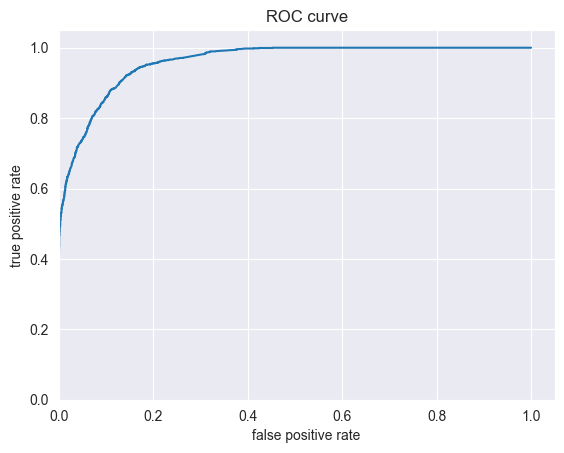

In [143]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [144]:
pr, rc, _ = precision_recall_curve(y, predictions_proba)

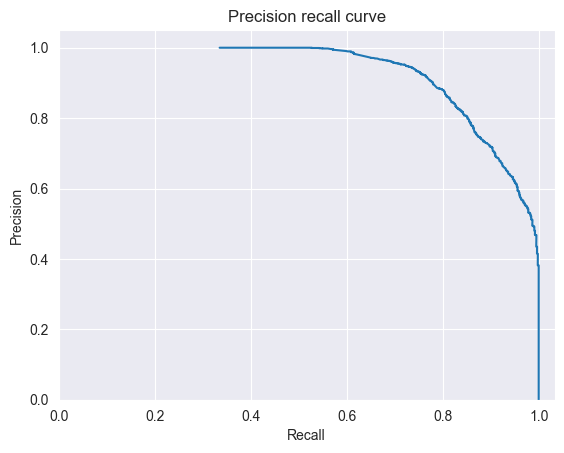

In [145]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

Confusion Matrix


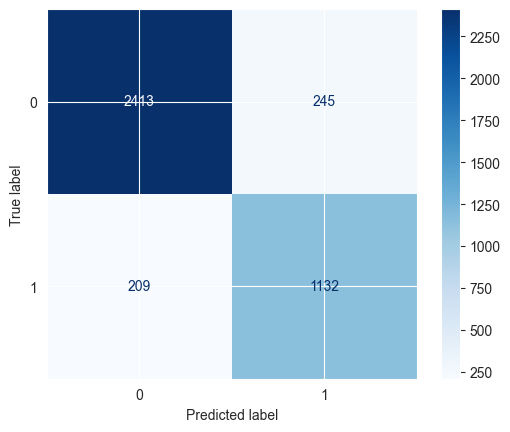

In [146]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()